In [3]:
import pandas as pd
from openai import OpenAI
import json
import re
from ast import literal_eval
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

# Calculating More Heurisitcs

In [7]:
from ast import literal_eval

df_conversations = pd.read_csv('conversations.csv', converters={"prompts": literal_eval, "answers": literal_eval, 'annotated_gaps': literal_eval})
df_conversations.head()

,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,prompts_fulltext
0,3,[{No gap}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",You are an expert search query generator.\n\nI...
1,4,[{No gap}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,Please analyse the text below to find the root...
2,5,"[{missing specification, missing context}, {mi...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",https://github.com/arakoodev/EdgeChains can th...
3,6,"[{unclear instruction, missing context}, {No g...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,DeviceData.jsJavaScriptThe attached Next.js pa...
4,7,"[{No gap}, {multiple context, unclear instruct...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...","how to make pdf downloader through HTML , CSS ..."


In [11]:
client = OpenAI(api_key='KEY')

prompts_codes = []
answers_codes = []

prompts_errors = []
answers_errors = []

schema = {
    "type": "object",
      "properties": {
        "codes": {
          "type": "array",
          "description": "A list of all the codes from different programming languages and terminal commands extracted from the text",
          "items": {"type": "string"}
        },
        "errors": {
          "type": "array",
          "description": "A list of all the error logs and stack traces from different programming languages and terminal commands extracted from the text",
          "items": {"type": "string"}
        },
      }
}
i = 0
for index, row in df_conversations.iterrows():
    print(i)
    i += 1
    prompts = row['prompts']
    answers = row['answers']

    temp2 = []
    temp4 = []

    for prompt in prompts:
      m = ('Given the documents containing text, which may include code snippets and error logs in various programming languages or terminal commands, '
          'your goal is to extract these code snippets and error logs and format them into a JSON object. The JSON object should have two keys: "codes" and "errors". '
          'The "codes" key should contain a list of all extracted code snippets. Code snippets should only be in the form of code or terminal command, and they should not be in the form of natural language. The "errors" key should contain a list of all extracted error logs and stack traces seen in terminal or programming languages.'
          ' Phrases in the form of question, statements, or natural language that are used for communication should not be considered as code or error log. Codes and error logs should strickly only be in the form of a programming language syntax or terminal command. '
          'The following is an example of the task you are going to deliver:\n'
          'Document: "Write me a bash script. Something along the lines of echo "Hello, World!" or the following:\nWhile true\ndo\nif [[ traffic on Steam\'s port number == 0 MB/s for 5 minutes ]] ; then\nshutdown now\ndone\ni tried writing my own code but i got this ArithmeticException Error:\nException in thread "main" java.lang.ArithmeticException: / by zero\n    at com.example.Calculator.divide(Calculator.java:12)\n    at com.example.Main.main(Main.java:8)\n" The command doesnt add any crypto data to Makefile, can I add it myself? wheres snmpd.conf again?\n'
          'Output: {{"codes": ["echo \"Hello, World!\"", "While true\ndo\nif [[ traffic on Steam\'s port number == 0 MB/s for 5 minutes ]] ; then\nshutdown now\ndone\n"], "errors": ["Exception in thread \"main\" java.lang.ArithmeticException: / by zero\n    at com.example.Calculator.divide(Calculator.java:12)\n    at com.example.Main.main(Main.java:8)"]}}\n'
          'Now, this is the document that you are going to analyze and provide the json output for: '
          '{prompt_text}'.format(prompt_text=prompt)
          )
      message = {"role": "user", "content": m}
      
      completion = client.chat.completions.create(
          model="gpt-4o",
          messages=[
              {"role": "system", "content": "You are a helpful assistant for separating code, stack traces, and error messages from text."},
              message
          ],
          temperature=0,
          tools= [{'type': 'function', 'function': {'name':'set_schema', 'parameters': schema}}],
          tool_choice= {'type': 'function', 'function': {'name':'set_schema'}}
      )

      gpt_answer = completion.choices[0].message.tool_calls[0].function.arguments
      json_obj = json.loads(gpt_answer)
      if json_obj.get('codes') is not None:
        temp2.extend(json_obj.get('codes'))
      if json_obj.get('errors') is not None:
        temp4.extend(json_obj.get('errors'))
    
    prompts_codes.append(temp2)
    prompts_errors.append(temp4)
    # if i==100:
    #   break
df_conversations['prompts_codes'] = prompts_codes
df_conversations['prompts_errors'] = prompts_errors
df_conversations.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,prompts_fulltext,prompts_codes,prompts_errors
0,3,[{No gap}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",You are an expert search query generator.\n\nI...,[],[]
1,4,[{No gap}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,Please analyse the text below to find the root...,[],[]
2,5,"[{missing specification, missing context}, {mi...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",https://github.com/arakoodev/EdgeChains can th...,[],[]
3,6,"[{unclear instruction, missing context}, {No g...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,DeviceData.jsJavaScriptThe attached Next.js pa...,"[console.log(""getDeviceInfo API called"");, get...",[DeviceData.js:11 GET https://pguidev.plas...
4,7,"[{No gap}, {multiple context, unclear instruct...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...","how to make pdf downloader through HTML , CSS ...",[],[]


In [15]:
def extract_code_blocks(text):
    code_blocks = re.findall(r'```(?:.*?)```|`[^`\n]*`', text, re.DOTALL)
    return code_blocks

answers_code_blocks = []
prompts_code_blocks = []

for index, row in df_conversations.iterrows():
    answers = row['answers']
    temp = []
    for answer in answers:
        blokcs = extract_code_blocks(answer)
        if len(blokcs) == 0:
            continue
        temp.extend(blokcs)
    answers_code_blocks.append(temp)

for index, row in df_conversations.iterrows():
    prompts = row['prompts']
    temp = []
    for prompt in prompts:
        blokcs = extract_code_blocks(prompt)
        if len(blokcs) == 0:
            continue
        temp.extend(blokcs)
    prompts_code_blocks.append(temp)

df_conversations['prompts_code_blocks'] = prompts_code_blocks
df_conversations['answers_codes'] = answers_code_blocks

In [14]:
# Adapted from https://gist.github.com/winzig/8894715

url_re = r"""
(?xi)
\b
(                                       # Capture 1: entire matched URL
  (?:
    https?:                             # URL protocol and colon
    (?:
      /{1,3}                            # 1-3 slashes
      |                                 #   or
      [a-z0-9%]                         # Single letter or digit or '%'
                                        # (Trying not to match e.g. "URI::Escape")
    )
    |                                   #   or
                                        # looks like domain name followed by a slash:
    [a-z0-9.\-]+[.]
    (?:[a-z]{2,13})
    /
  )
  (?:                                   # One or more:
    [^\s()<>{}\[\]]+                    # Run of non-space, non-()<>{}[]
    |                                   #   or
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\)  # balanced parens, one level deep: (…(…)…)
    |
    \([^\s]+?\)                         # balanced parens, non-recursive: (…)
  )+
  (?:                                   # End with:
    \([^\s()]*?\([^\s()]+\)[^\s()]*?\)  # balanced parens, one level deep: (…(…)…)
    |
    \([^\s]+?\)                         # balanced parens, non-recursive: (…)
    |                                   #   or
    [^\s`!()\[\]{};:'".,<>?«»“”‘’]      # not a space or one of these punct chars
  )
  |                                     # OR, the following to match naked domains:
  (?:\b
    (?<![@.])                           # not preceded by a @, avoid matching foo@_gmail.com_
    [a-z0-9]+
    (?:[.\-][a-z0-9]+)*
    [.]
    (?:[a-z]{2,13})
    \b
    /?
    (?!@)                               # not succeeded by a @, avoid matching "foo.na" in "foo.na@example.com"
    /                                   # nkraft: followed by a slash to avoid field or method accesses (e.g., Set.size)
  )
)
"""

# Sample text containing URLs
text = "This is a sample text with a URL: example.com and another URL: https://example.org/path?param=value"

# Find all URLs in the text
urls = re.findall(url_re, text)

# Print the found URLs
print(urls)

['https://example.org/path?param=value']


/var/folders/yw/_r3bbrhj0kvg4v__qxmvpmkdvjb0dd/T/ipykernel_89355/3550177340.py:54: DeprecationWarning: Flags not at the start of the expression '\n(?xi)\n\\b\n(         ' (truncated) but at position 1
  urls = re.findall(url_re, text)


In [16]:
clean_prompts = []
clean_answers = []
for index, row in df_conversations.iterrows():
    prompts_fulltext = row['prompts_fulltext']
    answers_fulltext = row['answers_fulltext']
    prompts_codes = row['prompts_codes']
    prompts_code_blocks = row['prompts_code_blocks']
    prompts_errors = row['prompts_errors']
    answers_codes = row['answers_codes']

    for pr_error in prompts_errors:
        if len(pr_error) == 0 or len(pr_error) == 1:
            continue
        prompts_fulltext = prompts_fulltext.replace(pr_error, '[ERROR]', 1)
    for pr_code in prompts_codes:
        if len(pr_code) == 0 or len(pr_code) == 1:
            continue
        prompts_fulltext = prompts_fulltext.replace(pr_code, '[CODE]', 1)
    for pr_code in prompts_code_blocks:
        if len(pr_code) == 0 or len(pr_code) == 1:
            continue
        prompts_fulltext = prompts_fulltext.replace(pr_code, '[CODE]', 1)
    # for pr_code in prompts_codes:
    #     if len(pr_code) == 0 or len(pr_code) == 1:
    #         continue
    #     pr_code = pr_code.replace('\n', '').replace('\t', '')
    #     prompts_fulltext = prompts_fulltext.replace('\n', '').replace('\t', '')
    #     prompts_fulltext = prompts_fulltext.replace(pr_code, ' [CODE] ', 1)
    
    for an_code in answers_codes:
        if len(an_code) == 0 or len(an_code) == 1:
            continue
        answers_fulltext = answers_fulltext.replace(an_code, '[CODE]', 1)

    prompts_fulltext = re.sub(url_re, '[URL]', prompts_fulltext)
    answers_fulltext = re.sub(url_re, '[URL]', answers_fulltext)

    clean_prompts.append(prompts_fulltext)
    clean_answers.append(answers_fulltext)

df_conversations['prompts_fulltext_clean'] = clean_prompts
df_conversations['answers_fulltext_clean'] = clean_answers
df_conversations.head()

,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,prompts_fulltext,prompts_codes,prompts_errors,prompts_code_blocks,answers_codes,prompts_fulltext_clean,answers_fulltext_clean
0,3,[{No gap}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",You are an expert search query generator.\n\nI...,[],[],[],[],You are an expert search query generator.\n\nI...,"Certainly, here are 10 high-quality search que..."
1,4,[{No gap}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,Please analyse the text below to find the root...,[],[],[],[],Please analyse the text below to find the root...,Here is the JSON output analyzing the root cau...
2,5,"[{missing specification, missing context}, {mi...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",https://github.com/arakoodev/EdgeChains can th...,[],[],[],[],[URL] can this be used from python:\n[URL] giv...,"Finished browsingShow workHide workEdgeChains,..."
3,6,"[{unclear instruction, missing context}, {No g...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,DeviceData.jsJavaScriptThe attached Next.js pa...,"[console.log(""getDeviceInfo API called"");, get...",[DeviceData.js:11 GET https://pguidev.plas...,"[`options`, `object`, `ForwardRef(Autocomplete...","[`rds-ca-2019-root.pem`, `rds-ca-2015-root.pem...",DeviceData.jsJavaScriptThe attached Next.js pa...,The error messages you provided give insight i...
4,7,"[{No gap}, {multiple context, unclear instruct...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...","how to make pdf downloader through HTML , CSS ...",[],[],[],"[`requests`, `BeautifulSoup`, `input()`, `open...","how to make pdf downloader through HTML , CSS ...","Creating a PDF downloader through HTML, CSS, J..."


In [164]:
df_conversations.to_csv('./conversations_heuristics.csv', index=False)

In [4]:
df_conversations = pd.read_csv('conversations_heuristics.csv', converters={"prompts": literal_eval, "answers": literal_eval})
df_conversations.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,...,subordinate_clauses_list,num_entities,first_prompt_length,num_repeated_3_grams,num_repeated_2_grams,entailment,neutral,contradiction,num_unresolved_ref,prompts_fulltext_clean
0,0,0,0,3,[{'No gap'}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",...,0,13,216,8,12,0.064329,0.734123,0.201548,6,You are an expert search query generator.\n\nI...
1,1,1,1,4,[{'No gap'}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,...,6,47,1727,60,153,0.272672,0.711683,0.015645,15,Please analyse the text below to find the root...
2,2,2,2,5,"[{'missing specification', 'missing context'},...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",...,0,0,1,0,0,0.054083,0.517871,0.428046,1,[URL] can this be used from python:\n[URL] giv...
3,3,3,3,6,"[{'unclear instruction', 'missing context'}, {...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,...,12,41,270,11,46,0.201644,0.774855,0.023501,55,DeviceData.jsJavaScriptThe attached Next.js pa...
4,4,4,4,7,"[{'No gap'}, {'multiple context', 'unclear ins...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...",...,0,3,13,1,4,0.021345,0.264188,0.714467,3,"how to make pdf downloader through HTML , CSS ..."


In [83]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize

# Ensure you have the necessary NLTK resources
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')

def count_constraints_modifiers_subordinate_clauses(prompt):
    # Tokenize the prompt into sentences
    sentences = sent_tokenize(prompt)
    
    constraints_count = 0
    modifiers_count = 0
    subordinate_clauses_count = 0

    for sentence in sentences:
        # Tokenize each sentence into words
        words = word_tokenize(sentence)
        # Get the part-of-speech tags for the words
        pos_tags = pos_tag(words)

        # Count constraints (e.g., 'if', 'unless', 'provided that', 'in case of')
        constraints_keywords = {'if', 'unless', 'provided', 'in case', 'only'}
        constraints_count += sum(1 for word, tag in pos_tags if word.lower() in constraints_keywords)

        # Count modifiers (e.g., adjectives, adverbs)
        modifiers_count += sum(1 for word, tag in pos_tags if tag in ['JJ', 'RB'])

        # Count subordinate clauses (usually starts with subordinating conjunctions)
        subordinate_conjunctions = {'although', 'because', 'since', 'while', 'if', 'when', 'after', 'before'}
        subordinate_clauses_count += sum(1 for word, tag in pos_tag(words) if word.lower() in subordinate_conjunctions)

    return constraints_count, modifiers_count, subordinate_clauses_count

constraints_list = []
modifiers_list = []
subordinate_clauses_list = []

for index, row in df_conversations.iterrows():
    full_clean_text = row['prompts_fulltext_clean']
    constraints, modifiers, subordinate_clauses = count_constraints_modifiers_subordinate_clauses(full_clean_text)

    constraints_list.append(constraints)
    modifiers_list.append(modifiers)
    subordinate_clauses_list.append(subordinate_clauses)

df_conversations['constraints_list'] = constraints_list
df_conversations['modifiers_list'] = modifiers_list
df_conversations['subordinate_clauses_list'] = subordinate_clauses_list

[nltk_data] Downloading package punkt to /Users/re378/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/re378/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/re378/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/re378/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [84]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_md")

def count_named_entities(prompt):
    # Process the text with spaCy
    doc = nlp(prompt)
    
    # Extract named entities
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]
    
    # Count the named entities
    entities_count = len(named_entities)
    
    return entities_count

entities_list = []

for index, row in df_conversations.iterrows():
    full_clean_text = row['prompts_fulltext_clean']
    num_entities = count_named_entities(full_clean_text)

    entities_list.append(num_entities)

df_conversations['num_entities'] = entities_list

In [85]:
def calculate_first_prompt_length(prompts):
    """
    Calculate the length of the first prompt in terms of word count and character count.

    Args:
    prompts (list of str): A list containing prompts from the conversation.

    Returns:
    tuple: A tuple containing the word count and character count of the first prompt.
    """
    if not prompts:
        return 0  # Return 0 if no prompts are provided

    first_prompt = prompts[0]  # Get the first prompt

    word_count = len(first_prompt.split())  # Count the number of words

    return word_count

first_prompt_list = []

for index, row in df_conversations.iterrows():
    prompts = row['prompts']
    first_prompt_length = calculate_first_prompt_length(prompts)

    first_prompt_list.append(first_prompt_length)

df_conversations['first_prompt_length'] = first_prompt_list

In [86]:
from collections import Counter

def extract_ngrams(text, n):
    """
    Extract n-grams from the text.

    Args:
    text (str): The input text (a prompt).
    n (int): The length of n-grams to extract.

    Returns:
    list: A list of n-grams from the input text.
    """
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    return ngrams

def count_repeated_ngrams(prompt, n=2):
    """
    Calculate the number of repeated n-grams in a list of prompts.

    Args:
    prompts (list of str): A list of prompts (each prompt is a string).
    n (int): The length of n-grams to look for (default is 2, i.e., bigrams).

    Returns:
    int: The number of repeated n-grams across all prompts.
    """
    all_ngrams = []

    # Extract n-grams from each prompt and add them to the list
    all_ngrams.extend(extract_ngrams(prompt, n))
    
    # Count the occurrences of each n-gram
    ngram_counts = Counter(all_ngrams)
    
    # Count the number of n-grams that occur more than once
    repeated_ngrams_count = sum(1 for count in ngram_counts.values() if count > 1)

    return repeated_ngrams_count

repeated_3_grams_list = []
repeated_2_grams_list = []

for index, row in df_conversations.iterrows():
    full_clean_text = row['prompts_fulltext_clean']
    num_repeated_3_grams = count_repeated_ngrams(full_clean_text, 3)

    repeated_3_grams_list.append(num_repeated_3_grams)

    num_repeated_2_grams = count_repeated_ngrams(full_clean_text, 2)

    repeated_2_grams_list.append(num_repeated_2_grams)

df_conversations['num_repeated_3_grams'] = repeated_3_grams_list
df_conversations['num_repeated_2_grams'] = repeated_2_grams_list

In [87]:
df_conversations.head(n=20)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,...,subordinate_clauses_list,num_entities,first_prompt_length,num_repeated_3_grams,num_repeated_2_grams,entailment,neutral,contradiction,num_unresolved_ref,prompts_fulltext_clean
0,0,0,0,3,[{'No gap'}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",...,0,13,216,8,12,0.064329,0.734124,0.201547,6,You are an expert search query generator.\n\nI...
1,1,1,1,4,[{'No gap'}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,...,6,47,1727,60,153,0.272672,0.711683,0.015645,15,Please analyse the text below to find the root...
2,2,2,2,5,"[{'missing specification', 'missing context'},...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",...,0,0,1,0,0,0.054083,0.517871,0.428047,1,[URL] can this be used from python:\n[URL] giv...
3,3,3,3,6,"[{'unclear instruction', 'missing context'}, {...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,...,12,41,270,11,46,0.201644,0.774854,0.023501,54,DeviceData.jsJavaScriptThe attached Next.js pa...
4,4,4,4,7,"[{'No gap'}, {'multiple context', 'unclear ins...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...",...,0,3,13,1,4,0.021345,0.264188,0.714467,3,"how to make pdf downloader through HTML , CSS ..."
5,5,5,5,8,"[{'missing context'}, {'No gap'}]",[How to run a java class inside of a container...,[To run a Java class inside a container using ...,directive prompting,closed,To run a Java class inside a container using T...,...,0,0,12,1,2,0.018060,0.939330,0.042610,1,How to run a java class inside of a container ...
6,6,6,6,9,"[{'No gap'}, {'No gap'}, {'No gap'}]",[How to add a java class in a generic containe...,[To add a Java class in a generic container fr...,reflection,closed,To add a Java class in a generic container fro...,...,0,0,17,1,4,0.385202,0.430229,0.184569,2,How to add a java class in a generic container...
7,7,7,7,12,[{'No gap'}],[I have a django and rasa application (rasa is...,[If you want to set a URL for the Rasa applica...,directive prompting,open,If you want to set a URL for the Rasa applicat...,...,0,0,40,0,1,0.003798,0.983779,0.012423,4,I have a django and rasa application (rasa is ...
8,8,8,8,14,"[{'missing specification', 'missing context'},...",[Can I use local storage in the browser to sto...,"[Yes, you can use the browser's local storage ...",chain-of-thought (cot),open,"Yes, you can use the browser's local storage t...",...,1,0,17,2,6,0.026539,0.952437,0.021025,6,Can I use local storage in the browser to stor...
9,9,9,9,15,[{'missing context'}],[Execution failed for task ':app:mergeSsoDebug...,[The error message you're encountering is rela...,directive prompting,closed,The error message you're encountering is relat...,...,0,0,540,0,0,0.247526,0.261670,0.490804,0,[ERROR]\n\n* Exception is:\n[ERROR]\n\n\n\n


In [160]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [161]:
import torch

In [162]:
# Load model and tokenizer
model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [163]:
def get_ambiguity_score(text):
    # Tokenize and prepare input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    # Get probabilities
    probs = torch.softmax(logits, dim=-1)
    entailment = probs[0][0].item()
    neutral = probs[0][1].item()
    contradiction =  probs[0][2].item()
    return entailment, neutral, contradiction

entailment_list = []
neutral_list = []
contradiction_list = []

for index, row in df_conversations.iterrows():
    full_clean_text = row['prompts_fulltext_clean']
    entailment, neutral, contradiction = get_ambiguity_score(full_clean_text)

    entailment_list.append(entailment)
    neutral_list.append(neutral)
    contradiction_list.append(contradiction)

df_conversations['entailment'] = entailment_list
df_conversations['neutral'] = neutral_list
df_conversations['contradiction'] = contradiction_list

In [69]:
def get_prompt_count(prompts):
    return len(prompts)

total_prompt_count_list = []

for index, row in df_conversations.iterrows():
    prompts = row['prompts']
    total_prompt_count = get_prompt_count(prompts)

    total_prompt_count_list.append(total_prompt_count)

df_conversations['total_prompt_count'] = total_prompt_count_list

In [72]:
df_conversations.head(n=10)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,conversation_id,annotated_gaps,prompts,answers,processed_style,status,answers_fulltext,...,num_entities,first_prompt_length,num_repeated_3_grams,num_repeated_2_grams,entailment,neutral,contradiction,num_unresolved_ref,prompts_fulltext_clean,total_prompt_count
0,0,0,0,3,[{'No gap'}],[You are an expert search query generator.\n\n...,"[Certainly, here are 10 high-quality search qu...",persona,closed,"Certainly, here are 10 high-quality search que...",...,13,216,8,12,0.064329,0.734123,0.201548,6,You are an expert search query generator.\n\nI...,1
1,1,1,1,4,[{'No gap'}],[Please analyse the text below to find the roo...,[Here is the JSON output analyzing the root ca...,chain-of-thoughts(cot),closed,Here is the JSON output analyzing the root cau...,...,47,1727,60,153,0.272672,0.711683,0.015645,15,Please analyse the text below to find the root...,1
2,2,2,2,5,"[{'missing specification', 'missing context'},...","[https://github.com/arakoodev/EdgeChains, can ...",[Finished browsingShow workHide workEdgeChains...,directive prompting,open,"Finished browsingShow workHide workEdgeChains,...",...,0,1,0,0,0.054083,0.517871,0.428046,1,[URL] can this be used from python:\n[URL] giv...,4
3,3,3,3,6,"[{'unclear instruction', 'missing context'}, {...",[DeviceData.jsJavaScriptThe attached Next.js p...,[The error messages you provided give insight ...,chain-of-thought (cot),open,The error messages you provided give insight i...,...,41,270,11,46,0.201644,0.774855,0.023501,55,DeviceData.jsJavaScriptThe attached Next.js pa...,28
4,4,4,4,7,"[{'No gap'}, {'multiple context', 'unclear ins...","[how to make pdf downloader through HTML , CSS...","[Creating a PDF downloader through HTML, CSS, ...",directive prompting,open,"Creating a PDF downloader through HTML, CSS, J...",...,3,13,1,4,0.021345,0.264188,0.714467,3,"how to make pdf downloader through HTML , CSS ...",2
5,5,5,5,8,"[{'missing context'}, {'No gap'}]",[How to run a java class inside of a container...,[To run a Java class inside a container using ...,directive prompting,closed,To run a Java class inside a container using T...,...,0,12,1,2,0.018060,0.939330,0.042610,1,How to run a java class inside of a container ...,2
6,6,6,6,9,"[{'No gap'}, {'No gap'}, {'No gap'}]",[How to add a java class in a generic containe...,[To add a Java class in a generic container fr...,reflection,closed,To add a Java class in a generic container fro...,...,0,17,1,4,0.385203,0.430228,0.184569,2,How to add a java class in a generic container...,3
7,7,7,7,12,[{'No gap'}],[I have a django and rasa application (rasa is...,[If you want to set a URL for the Rasa applica...,directive prompting,open,If you want to set a URL for the Rasa applicat...,...,0,40,0,1,0.003797,0.983779,0.012423,4,I have a django and rasa application (rasa is ...,1
8,8,8,8,14,"[{'missing specification', 'missing context'},...",[Can I use local storage in the browser to sto...,"[Yes, you can use the browser's local storage ...",chain-of-thought (cot),open,"Yes, you can use the browser's local storage t...",...,0,17,2,6,0.026539,0.952436,0.021025,6,Can I use local storage in the browser to stor...,4
9,9,9,9,15,[{'missing context'}],[Execution failed for task ':app:mergeSsoDebug...,[The error message you're encountering is rela...,directive prompting,closed,The error message you're encountering is relat...,...,0,540,0,0,0.247526,0.261670,0.490804,0,[ERROR]\n\n* Exception is:\n[ERROR]\n\n\n\n,1


## Analysis

In [64]:
df_conversations = pd.read_csv('conversations_heuristics.csv', converters={"prompts": literal_eval, "answers": literal_eval})

In [210]:
pd.set_option('display.max_columns', None)
summary_stats = df_conversations.describe(percentiles=[0.25, 0.5, 0.75, 0.9])
percentiles_summary = summary_stats.loc[['25%', '50%', '75%', '90%']]
print(percentiles_summary)

     Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  conversation_id  num_prim_quest  \
25%         108.0         108.0       108.0            174.0             0.0   
50%         216.0         216.0       216.0            308.0             1.0   
75%         324.0         324.0       324.0            434.0             2.0   
90%         388.8         388.8       388.8            522.8             4.0   

     num_prim_ks_ques  num_acc_ans  num_urls  num_code_snippets  \
25%               0.0          0.0       0.0                0.0   
50%               0.0          0.0       0.0                0.0   
75%               1.0          0.0       0.0                2.0   
90%               2.0          0.0       0.8                7.0   

     mean_size_code_snippets  num_api_calls_text  num_api_calls_code  \
25%                      0.0                 0.0                 0.0   
50%                      0.0                 0.0                 0.0   
75%                    134.5                 1.

In [73]:
categories = [
    "num_prim_quest", "num_prim_ks_ques", "num_acc_ans", "num_urls", "num_code_snippets", 
    "mean_size_code_snippets", "num_api_calls_text", "num_api_calls_code", "code_descs", "se_words", 
    "err_msgs", "distinct_words", "uniq_info", "misspelled", "incomplete_count", "complete_count", 
    "total_text_speak", "ARI", "Coleman_Liau", "Flesch_reading_ease", "Flesch_Kincaid_grade", 
    "Gunning_Fog", "Smog", "total_sent", "total_word_count", "constraints_list", "modifiers_list", 
    "subordinate_clauses_list", "num_entities", "first_prompt_length", "num_repeated_3_grams", 
    "num_repeated_2_grams", "entailment", "neutral", "contradiction", "num_unresolved_ref", "total_prompt_count"
]

developers_data_help = {
    "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [], "num_code_snippets": [], 
    "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [], 
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], 
    "complete_count": [], "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], 
    "Flesch_Kincaid_grade": [], "Gunning_Fog": [], "Smog": [], "total_sent": [], "total_word_count": [], 
    "constraints_list": [], "modifiers_list": [], "subordinate_clauses_list": [], "num_entities": [], 
    "first_prompt_length": [], "num_repeated_3_grams": [], "num_repeated_2_grams": [], "entailment": [], 
    "neutral": [], "contradiction": [], "num_unresolved_ref": [], "total_prompt_count": []
}

developers_data_no_help = {
    "num_prim_quest": [], "num_prim_ks_ques": [], "num_acc_ans": [], "num_urls": [], "num_code_snippets": [], 
    "mean_size_code_snippets": [], "num_api_calls_text": [], "num_api_calls_code": [], "code_descs": [], 
    "se_words": [], "err_msgs": [], "distinct_words": [], "uniq_info": [], "misspelled": [], "incomplete_count": [], 
    "complete_count": [], "total_text_speak": [], "ARI": [], "Coleman_Liau": [], "Flesch_reading_ease": [], 
    "Flesch_Kincaid_grade": [], "Gunning_Fog": [], "Smog": [], "total_sent": [], "total_word_count": [], 
    "constraints_list": [], "modifiers_list": [], "subordinate_clauses_list": [], "num_entities": [], 
    "first_prompt_length": [], "num_repeated_3_grams": [], "num_repeated_2_grams": [], "entailment": [], 
    "neutral": [], "contradiction": [], "num_unresolved_ref": [], "total_prompt_count": []
}

for index, row in df_conversations.iterrows():
    for cat in categories:
        if not np.isnan(row[cat]):
            if row['status'] == 'open':
                developers_data_no_help[cat].append(row[cat])
            elif row['status'] == 'closed':
                developers_data_help[cat].append(row[cat])

In [74]:
# Convert dictionaries to DataFrames
df_help = pd.DataFrame(developers_data_help)
df_no_help = pd.DataFrame(developers_data_no_help)

# Function to calculate min, median, max for each column
def calculate_stats(df):
    return pd.DataFrame({
        "min": df.apply(np.min),
        "median": df.apply(np.median),
        "max": df.apply(np.max)
    })

# Calculate stats for each dataset
stats_help = calculate_stats(df_help)
stats_no_help = calculate_stats(df_no_help)

# Display or print the results
print("Statistics for 'developers_data_help':")
print(stats_help)

print("\nStatistics for 'developers_data_no_help':")
print(stats_no_help)

Statistics for 'developers_data_help':
                                 min     median          max
num_prim_quest              0.000000   1.000000    68.000000
num_prim_ks_ques            0.000000   0.000000     7.000000
num_acc_ans                 0.000000   0.000000     0.000000
num_urls                    0.000000   0.000000    10.000000
num_code_snippets           0.000000   0.000000    77.000000
mean_size_code_snippets     0.000000   0.000000  3493.000000
num_api_calls_text          0.000000   0.000000    25.000000
num_api_calls_code          0.000000   0.000000    76.000000
code_descs                  0.000000   0.000000    94.000000
se_words                    0.000000   8.000000   185.000000
err_msgs                    0.000000   0.000000    34.000000
distinct_words              1.000000  38.500000   598.000000
uniq_info                   1.000000  11.000000    96.000000
misspelled                  0.000000   1.000000    14.000000
incomplete_count            0.000000   0.00000

In [239]:
p_values = []
significance = []

categories_spec = [
    "se_words", "num_entities", "constraints_list", "modifiers_list", "subordinate_clauses_list", "num_repeated_3_grams", 
    "num_repeated_2_grams"
]

categories_context = [
    "distinct_words", "uniq_info", "first_prompt_length", "num_code_snippets", 
    "mean_size_code_snippets", "num_api_calls_text", "code_descs", "num_urls", "total_sent", "total_word_count"
]

categories_clarity = [
    "misspelled", "incomplete_count", "Flesch_reading_ease", "Smog", "entailment", "num_unresolved_ref"
]


for cat in categories_spec:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = ttest_ind(dev_liwc_scores1, dev_liwc_scores2)

    # Output results
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(cat + ": Statistically significant difference")
    else:
        print(cat + ": No statistically significant difference")
    print("")
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)

p-value: 0.08224543785148801
se_words: No statistically significant difference

p-value: 0.013911833717577173
num_entities: Statistically significant difference

p-value: 0.5864615669091389
constraints_list: No statistically significant difference

p-value: 0.07192744522805081
modifiers_list: No statistically significant difference

p-value: 0.2756621677752441
subordinate_clauses_list: No statistically significant difference

p-value: 0.11361033585210109
num_repeated_3_grams: No statistically significant difference

p-value: 0.059420871913051516
num_repeated_2_grams: No statistically significant difference



In [240]:
# Convert p-values to a numpy array
p_values = np.array(p_values)

# Sort p-values and apply the Benjamini-Hochberg correction
sorted_indices = np.argsort(p_values)
sorted_p_values = p_values[sorted_indices]
m = len(p_values)
adjusted_p_values = np.zeros(m)

# Apply Benjamini-Hochberg formula
for i, p in enumerate(sorted_p_values):
    adjusted_p_values[i] = p * m / (i + 1)

# Ensure that the adjusted p-values are bounded by 1
adjusted_p_values = np.minimum(adjusted_p_values, 1.0)

# Map adjusted p-values back to the original order
adjusted_p_values_original_order = np.zeros(m)
adjusted_p_values_original_order[sorted_indices] = adjusted_p_values

# Print results and update significance list
for i, adj_p_value in enumerate(adjusted_p_values_original_order):
    p_values[i] = adj_p_value  # Update the p-values list with adjusted ones
    is_significant = adj_p_value < 0.05
    significance.append(is_significant)  # Significant if p-value < 0.05

    # Output results
    print(f"{categories_spec[i]} - Adjusted p-value: {adj_p_value}")
    if is_significant:
        print(f"{categories_spec[i]}: Statistically significant after Benjamini-Hochberg correction")
    else:
        print(f"{categories_spec[i]}: No statistically significant difference after Benjamini-Hochberg correction")
    print("")

se_words - Adjusted p-value: 0.14392951624010403
se_words: No statistically significant difference after Benjamini-Hochberg correction

num_entities - Adjusted p-value: 0.09738283602304021
num_entities: No statistically significant difference after Benjamini-Hochberg correction

constraints_list - Adjusted p-value: 0.5864615669091389
constraints_list: No statistically significant difference after Benjamini-Hochberg correction

modifiers_list - Adjusted p-value: 0.16783070553211854
modifiers_list: No statistically significant difference after Benjamini-Hochberg correction

subordinate_clauses_list - Adjusted p-value: 0.3216058624044515
subordinate_clauses_list: No statistically significant difference after Benjamini-Hochberg correction

num_repeated_3_grams - Adjusted p-value: 0.15905447019294153
num_repeated_3_grams: No statistically significant difference after Benjamini-Hochberg correction

num_repeated_2_grams - Adjusted p-value: 0.2079730516956803
num_repeated_2_grams: No statistic

In [241]:
p_values = []
significance = []

categories_spec = [
    "se_words", "num_entities", "constraints_list", "modifiers_list", "subordinate_clauses_list", "num_repeated_3_grams", 
    "num_repeated_2_grams"
]

categories_context = [
    "distinct_words", "uniq_info", "first_prompt_length", "num_code_snippets", 
    "mean_size_code_snippets", "code_descs", "num_urls", "total_sent", "total_word_count", "err_msgs", "total_prompt_count"
]

categories_clarity = [
    "misspelled", "incomplete_count", "ARI", "Coleman_Liau", "Flesch_reading_ease",
    "Gunning_Fog", "Smog", "entailment", "num_unresolved_ref"
]


for cat in categories_context:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]


    _, p_value = ttest_ind(dev_liwc_scores1, dev_liwc_scores2)

    # Output results
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(cat + ": Statistically significant difference")
    else:
        print(cat + ": No statistically significant difference")
    print("")
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)

p-value: 0.09588450930111392
distinct_words: No statistically significant difference

p-value: 0.9565427940318041
uniq_info: No statistically significant difference

p-value: 0.12087159601044978
first_prompt_length: No statistically significant difference

p-value: 0.3054039253058283
num_code_snippets: No statistically significant difference

p-value: 0.0008412652098382706
mean_size_code_snippets: Statistically significant difference

p-value: 0.026320245246337103
code_descs: Statistically significant difference

p-value: 0.31078962161949014
num_urls: No statistically significant difference

p-value: 0.09604315246805274
total_sent: No statistically significant difference

p-value: 0.061495935407894095
total_word_count: No statistically significant difference

p-value: 0.3075398700763191
err_msgs: No statistically significant difference

p-value: 0.021835076391054826
total_prompt_count: Statistically significant difference



In [242]:
# Convert p-values to a numpy array
p_values = np.array(p_values)

# Sort p-values and apply the Benjamini-Hochberg correction
sorted_indices = np.argsort(p_values)
sorted_p_values = p_values[sorted_indices]
m = len(p_values)
adjusted_p_values = np.zeros(m)

# Apply Benjamini-Hochberg formula
for i, p in enumerate(sorted_p_values):
    adjusted_p_values[i] = p * m / (i + 1)

# Ensure that the adjusted p-values are bounded by 1
adjusted_p_values = np.minimum(adjusted_p_values, 1.0)

# Map adjusted p-values back to the original order
adjusted_p_values_original_order = np.zeros(m)
adjusted_p_values_original_order[sorted_indices] = adjusted_p_values

# Print results and update significance list
for i, adj_p_value in enumerate(adjusted_p_values_original_order):
    p_values[i] = adj_p_value  # Update the p-values list with adjusted ones
    is_significant = adj_p_value < 0.05
    significance.append(is_significant)  # Significant if p-value < 0.05

    # Output results
    print(f"{categories_context[i]} - Adjusted p-value: {adj_p_value}")
    if is_significant:
        print(f"{categories_context[i]}: Statistically significant after Benjamini-Hochberg correction")
    else:
        print(f"{categories_context[i]}: No statistically significant difference after Benjamini-Hochberg correction")
    print("")

distinct_words - Adjusted p-value: 0.2109459204624506
distinct_words: No statistically significant difference after Benjamini-Hochberg correction

uniq_info - Adjusted p-value: 0.9565427940318041
uniq_info: No statistically significant difference after Benjamini-Hochberg correction

first_prompt_length - Adjusted p-value: 0.1899410794449925
first_prompt_length: No statistically significant difference after Benjamini-Hochberg correction

num_code_snippets - Adjusted p-value: 0.41993039729551396
num_code_snippets: No statistically significant difference after Benjamini-Hochberg correction

mean_size_code_snippets - Adjusted p-value: 0.009253917308220977
mean_size_code_snippets: Statistically significant after Benjamini-Hochberg correction

code_descs - Adjusted p-value: 0.09650756590323605
code_descs: No statistically significant difference after Benjamini-Hochberg correction

num_urls - Adjusted p-value: 0.34186858378143914
num_urls: No statistically significant difference after Benjami

In [243]:
p_values = []
significance = []

categories_spec = [
    "se_words", "num_entities", "constraints_list", "modifiers_list", "subordinate_clauses_list", "num_repeated_3_grams", 
    "num_repeated_2_grams"
]

categories_context = [
    "distinct_words", "uniq_info", "first_prompt_length", "num_code_snippets", 
    "mean_size_code_snippets", "num_api_calls_text", "code_descs", "num_urls", "total_sent", "total_word_count"
]

categories_clarity = [
    "misspelled", "incomplete_count", "Flesch_reading_ease", "Smog", "entailment", "num_unresolved_ref"
]


for cat in categories_clarity:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    _, p_value = ttest_ind(dev_liwc_scores1, dev_liwc_scores2)

    # Output results
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(cat + ": Statistically significant difference")
    else:
        print(cat + ": No statistically significant difference")
    
    p_values.append(p_value)
    significance.append(p_value < 0.05)

p-value: 0.002639747384675128
misspelled: Statistically significant difference
p-value: 0.2810557115325467
incomplete_count: No statistically significant difference
p-value: 0.4646005437887645
Flesch_reading_ease: No statistically significant difference
p-value: 0.35092229335651126
Smog: No statistically significant difference
p-value: 0.5115227820802781
entailment: No statistically significant difference
p-value: 0.12534720654065826
num_unresolved_ref: No statistically significant difference


In [244]:
# Convert p-values to a numpy array
p_values = np.array(p_values)

# Sort p-values and apply the Benjamini-Hochberg correction
sorted_indices = np.argsort(p_values)
sorted_p_values = p_values[sorted_indices]
m = len(p_values)
adjusted_p_values = np.zeros(m)

# Apply Benjamini-Hochberg formula
for i, p in enumerate(sorted_p_values):
    adjusted_p_values[i] = p * m / (i + 1)

# Ensure that the adjusted p-values are bounded by 1
adjusted_p_values = np.minimum(adjusted_p_values, 1.0)

# Map adjusted p-values back to the original order
adjusted_p_values_original_order = np.zeros(m)
adjusted_p_values_original_order[sorted_indices] = adjusted_p_values

# Print results and update significance list
for i, adj_p_value in enumerate(adjusted_p_values_original_order):
    p_values[i] = adj_p_value  # Update the p-values list with adjusted ones
    is_significant = adj_p_value < 0.05
    significance.append(is_significant)  # Significant if p-value < 0.05

    # Output results
    print(f"{categories_clarity[i]} - Adjusted p-value: {adj_p_value}")
    if is_significant:
        print(f"{categories_clarity[i]}: Statistically significant after Benjamini-Hochberg correction")
    else:
        print(f"{categories_clarity[i]}: No statistically significant difference after Benjamini-Hochberg correction")
    print("")

misspelled - Adjusted p-value: 0.01583848430805077
misspelled: Statistically significant after Benjamini-Hochberg correction

incomplete_count - Adjusted p-value: 0.5621114230650934
incomplete_count: No statistically significant difference after Benjamini-Hochberg correction

Flesch_reading_ease - Adjusted p-value: 0.5575206525465173
Flesch_reading_ease: No statistically significant difference after Benjamini-Hochberg correction

Smog - Adjusted p-value: 0.5263834400347669
Smog: No statistically significant difference after Benjamini-Hochberg correction

entailment - Adjusted p-value: 0.5115227820802781
entailment: No statistically significant difference after Benjamini-Hochberg correction

num_unresolved_ref - Adjusted p-value: 0.3760416196219748
num_unresolved_ref: No statistically significant difference after Benjamini-Hochberg correction



In [217]:
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_spec:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_diff = 100
        pos.append(cat)
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

se_words : -0.24648175712292447
num_entities : -0.6199666715740477
constraints_list : -0.12498951430249144
modifiers_list : -0.3717997717121929
subordinate_clauses_list : -0.24290076335877858
num_repeated_3_grams : -0.4270050560126896
num_repeated_2_grams : -0.4442869416871145
more in helpful:[]
less in helpful:['se_words', 'num_entities', 'constraints_list', 'modifiers_list', 'subordinate_clauses_list', 'num_repeated_3_grams', 'num_repeated_2_grams']


In [176]:
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_context:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_diff = 100
        pos.append(cat)
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

distinct_words : -0.22244271607152005
uniq_info : -0.004041897441873406
first_prompt_length : -0.2645390798498621
num_code_snippets : -0.26546771898046323
mean_size_code_snippets : -0.6278715571664488
num_api_calls_text : -0.4260424258698071
code_descs : -0.6789672418331503
num_urls : -0.34732824427480913
total_sent : -0.3283593127305894
total_word_count : -0.35763378574133964
more in helpful:[]
less in helpful:['distinct_words', 'uniq_info', 'first_prompt_length', 'num_code_snippets', 'mean_size_code_snippets', 'num_api_calls_text', 'code_descs', 'num_urls', 'total_sent', 'total_word_count']


In [177]:
# Lists to store relative differences
relative_differences = []

pos = []
neg = []
# Calculate relative differences for each LIWC category
for cat in categories_clarity:
    dev_liwc_scores1 = developers_data_help[cat]
    dev_liwc_scores2 = developers_data_no_help[cat]

    if len(dev_liwc_scores1) == 0 or len(dev_liwc_scores2) == 0:
        print(cat)
    
    mean_dev1 = sum(dev_liwc_scores1) / len(dev_liwc_scores1)
    mean_dev2 = sum(dev_liwc_scores2) / len(dev_liwc_scores2)

    if mean_dev2 == 0.0 and mean_dev1 != 0.0:
        relative_diff = 100
        pos.append(cat)
        relative_differences.append(100)
        continue
    if mean_dev2 == 0.0 and mean_dev1 == 0.0:
        relative_differences.append(0)
        print(cat)
        continue
    
    relative_diff = (mean_dev1 - mean_dev2) / ((mean_dev2))
    if not np.isnan(relative_diff):
        print(cat + " : " + str(relative_diff))
        if relative_diff > 0:
            pos.append(cat)
        elif relative_diff < 0:
            neg.append(cat)

        relative_differences.append(relative_diff)

print("more in helpful:" + str(pos))
print("less in helpful:" + str(neg))

misspelled : -0.5216575080189969
incomplete_count : -0.35329780301619806
ARI : -0.13388405439122178
Coleman_Liau : -0.08087359650273888
Flesch_reading_ease : 0.027827358939932923
Gunning_Fog : -0.1183775457791806
Smog : 0.09190859197116313
entailment : -0.05624348817627514
num_unresolved_ref : -0.27500164626146684
more in helpful:['Flesch_reading_ease', 'Smog']
less in helpful:['misspelled', 'incomplete_count', 'ARI', 'Coleman_Liau', 'Gunning_Fog', 'entailment', 'num_unresolved_ref']


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF and drop features with high VIF
def calculate_vif(X, thresh=5.0):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Print VIF values before removal
    print("Initial VIF values:")
    print(vif_data)
    
    # Iteratively remove features with VIF greater than the threshold
    while vif_data['VIF'].max() > thresh:
        # Identify feature with the highest VIF
        feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        print(f"Removing '{feature_to_remove}' with VIF: {vif_data['VIF'].max()}")
        
        # Drop the feature and recalculate VIF
        X = X.drop(columns=[feature_to_remove])
        vif_data = pd.DataFrame()
        vif_data['Feature'] = X.columns
        vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Print final VIF values
    print("Final VIF values:")
    print(vif_data)

    return X

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import matplotlib.pyplot as plt

X = df_conversations[categories_spec + categories_context + categories_clarity]
# Encode categorical variable 'status' (0 for 'open', 1 for 'closed')
y = df_conversations['status'].map({'open': 0, 'closed': 1})



# Assuming you have your data (X, y) ready
# X is your feature matrix and y is the target (1 for closed/success, 0 for otherwise)

# Step 1: Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Step 2: Remove features with high VIF
X_vif_filtered = calculate_vif(X_scaled_df, thresh=5.0)

Initial VIF values:
                     Feature         VIF
0                   se_words   23.957030
1               num_entities   10.528899
2           constraints_list    6.352145
3             modifiers_list   65.110855
4   subordinate_clauses_list    7.601043
5       num_repeated_3_grams   46.212504
6       num_repeated_2_grams  206.341412
7             distinct_words   66.440242
8                  uniq_info    2.349937
9        first_prompt_length    1.715462
10         num_code_snippets    2.926062
11   mean_size_code_snippets    1.273313
12        num_api_calls_text   10.991954
13                code_descs    3.401340
14                  num_urls    2.467484
15                total_sent   86.931011
16          total_word_count  469.840391
17                  err_msgs    1.911737
18                misspelled    3.990150
19          incomplete_count   17.093870
20                       ARI   17.083412
21              Coleman_Liau    9.791934
22       Flesch_reading_ease    3.874

In [112]:
# Step 3: Feature Selection using Recursive Feature Elimination (RFE)
logreg = LogisticRegression(max_iter=1000)

# Apply RFE to select top N features (adjust n_features_to_select as needed)
rfe = RFE(logreg, n_features_to_select=15)
rfe.fit(X_vif_filtered, y)

# Get selected features
selected_features = X_vif_filtered.columns[rfe.support_]
print(f'Selected Features: {selected_features}')

Selected Features: Index(['subordinate_clauses_list', 'uniq_info', 'first_prompt_length',
       'num_code_snippets', 'mean_size_code_snippets', 'num_api_calls_code',
       'code_descs', 'misspelled', 'incomplete_count', 'Coleman_Liau',
       'Flesch_reading_ease', 'Gunning_Fog', 'Smog', 'entailment',
       'contradiction'],
      dtype='object')



Trying RobustScaler...
Cross-validated accuracy: 0.6166265704357125


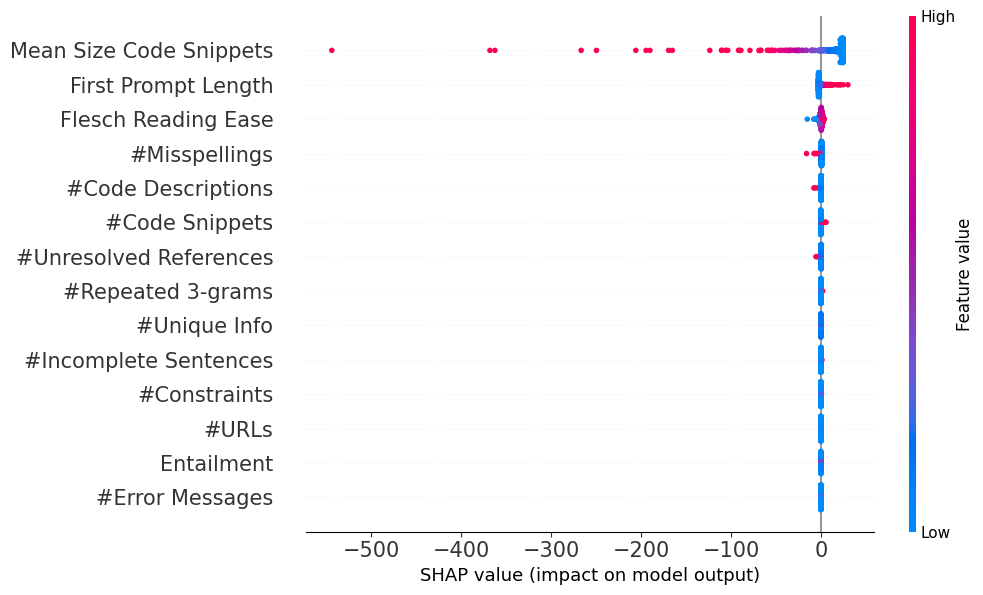

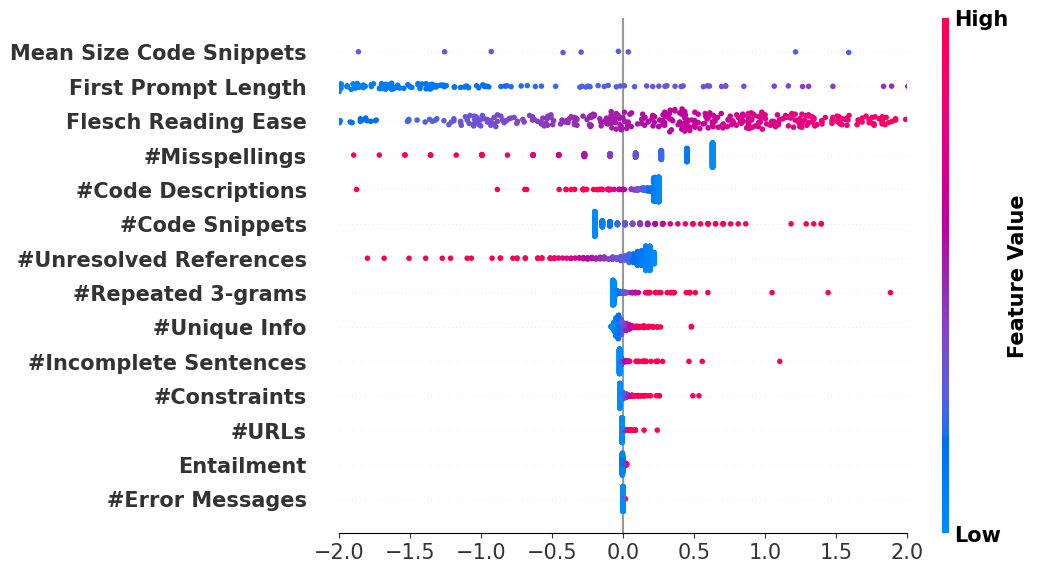

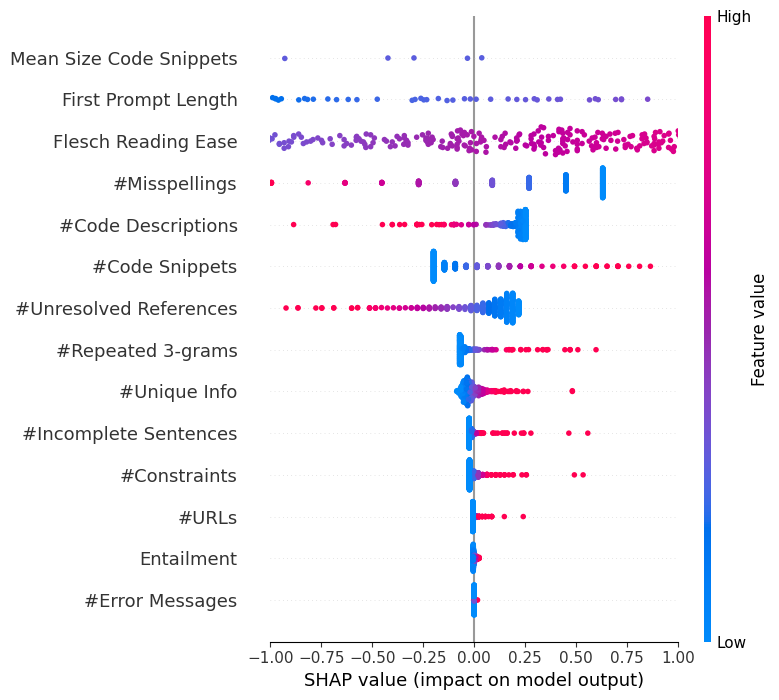

[0.63218391 0.64367816 0.57471264 0.61627907 0.61627907]

Comparison of scaling methods:
RobustScaler: 0.6166265704357125


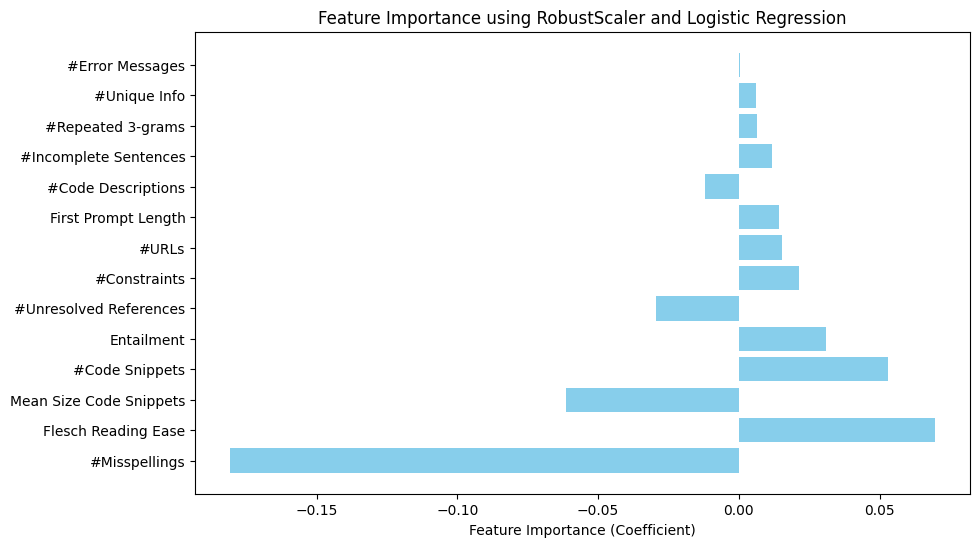

In [247]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import shap  # Import SHAP library
import joblib  # For saving the model

# Define a function to apply scaling, evaluate performance, and extract feature importances
def try_scaling(scaling_method, X, y):
    print(f"\nTrying {scaling_method.__class__.__name__}...")

    # Create the pipeline with scaling and logistic regression
    pipeline = Pipeline([
        ('scaler', scaling_method),
        # ('rfe', RFE(LogisticRegressionCV(cv=5, max_iter=1000, penalty='l1', solver='liblinear'), n_features_to_select=12)),  # Feature selection
        ('log_reg', LogisticRegressionCV(cv=5, max_iter=2000, penalty='l1', solver='liblinear', random_state=66))
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy: {cv_scores.mean()}")

    # Fit the pipeline to get feature importances
    pipeline.fit(X, y)

    joblib.dump(pipeline, "best_model.pkl")
    
    # Get the logistic regression model from the pipeline
    log_reg_model = pipeline.named_steps['log_reg']
    
    # Get feature importances (coefficients)
    feature_importances = log_reg_model.coef_[0]
    
    # Get feature names
    feature_names = X.columns if isinstance(X, pd.DataFrame) else np.arange(X.shape[1])

    # Use SHAP to explain the model predictions
    explainer = shap.Explainer(log_reg_model, X)
    shap_values = explainer.shap_values(X)

    # Plot SHAP values
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Set font size within shap summary plot
    shap.summary_plot(shap_values, X, show=False, plot_size=(10, 6), plot_type="dot")  # Adjust plot_size if needed

    # Adjust axes limits and font sizes for ticks
    # ax.set_xlim(-100, 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Save the plot after the shap.summary_plot command
    plt.savefig("shap_summary_plot2.png", bbox_inches="tight", dpi=300, format="png")

    # Plot SHAP values
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Set font size within shap summary plot
    shap.summary_plot(shap_values, X, show=False, plot_size=(10, 6), plot_type="dot")  # Adjust plot_size if needed
    color_bar = plt.gcf().axes[-1]  # Access the color bar
    color_bar.set_ylabel("Feature Value", fontsize=15, fontweight="bold")
    color_bar.yaxis.get_ticklabels()[0].set_fontweight("bold")  # Make 'Low' bold
    color_bar.yaxis.get_ticklabels()[-1].set_fontweight("bold") 
    color_bar.yaxis.get_ticklabels()[0].set_fontsize(15)  # Make 'Low' bold
    color_bar.yaxis.get_ticklabels()[-1].set_fontsize(15) 

    # Adjust axes limits and font sizes for ticks
    ax.set_xlim(-2, 2)
    ax.set_xlabel("")  # Remove x-axis title

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15, fontweight="bold")

    # Save the plot after the shap.summary_plot command
    plt.savefig("shap_summary_plot.png", bbox_inches="tight", dpi=300, format="png")

    # Plot SHAP values
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    # You can change the min and max value of xaxis by changing the arguments of:
    ax.set_xlim(-1, 1)  
    shap.summary_plot(shap_values, X)

    print(cv_scores)
    
    return cv_scores.mean(), feature_names, feature_importances

# Load your data
# Assume X (features) and y (target) are defined as before
categories_spec = [
    "constraints_list", "num_repeated_3_grams"]

categories_context = [
    "uniq_info", "first_prompt_length", "num_code_snippets", 
    "mean_size_code_snippets", "code_descs", "num_urls", "err_msgs"
]

categories_clarity = [
    "misspelled", "incomplete_count", "Flesch_reading_ease", "entailment", "num_unresolved_ref"
]

X = df_conversations[categories_spec + categories_context + categories_clarity]
X = X.rename(columns={'constraints_list': '#Constraints', 'num_repeated_3_grams': '#Repeated 3-grams',
                      'uniq_info': '#Unique Info', 'first_prompt_length': 'First Prompt Length', 'num_code_snippets': '#Code Snippets', 'mean_size_code_snippets':'Mean Size Code Snippets',
                      'code_descs': '#Code Descriptions', 'num_urls': '#URLs', 'err_msgs': '#Error Messages', 'misspelled': '#Misspellings', 'incomplete_count': '#Incomplete Sentences', 'Flesch_reading_ease': 'Flesch Reading Ease',
                      'entailment': 'Entailment', 'num_unresolved_ref': '#Unresolved References'})

# Encode categorical variable 'status' (0 for 'open', 1 for 'closed')
y = df_conversations['status'].map({'open': 0, 'closed': 1})
trained_feature_names = X.columns  # From original training DataFrame
# Create scalers
scalers = [RobustScaler()]

# Try each scaling method and store the results
results = {}
importances = {}
for scaler in scalers:
    accuracy, feature_names, feature_importance = try_scaling(scaler, X, y)
    results[scaler.__class__.__name__] = accuracy
    importances[scaler.__class__.__name__] = (feature_names, feature_importance)

# Show the results for comparison
print("\nComparison of scaling methods:")
for scaler, accuracy in results.items():
    print(f"{scaler}: {accuracy}")

# Plot feature importances for the best scaling method (RobustScaler)
best_scaler = 'RobustScaler'
feature_names, feature_importance = importances[best_scaler]

# Sort the feature importances by absolute value
sorted_indices = np.argsort(np.abs(feature_importance))[::-1]
sorted_feature_names = feature_names[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance, color='skyblue')
plt.xlabel('Feature Importance (Coefficient)')
plt.title('Feature Importance using RobustScaler and Logistic Regression')
plt.show()
